Data from https://www.ncei.noaa.gov/products/optimum-interpolation-sst

The anomaly data has the shape (1, 1, 720, 1440). We can just keep the last two indeces!

In [1]:
# Math libraries
import numpy as np
# For opening data files
import xarray as xr
# For regridding data
import xesmf as xe

# To find files
import os

# Functools partial for preprocess step of unpacking data
from functools import partial

# Plotting libraries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%config InlineBackend.figure_format='retina'

In [2]:
# SST data file paths
files = filter(lambda file : file[-2:] == 'nc', os.listdir('./data'))
# Adding ./data to path name
files = np.array(list(map(lambda f: './data/' + f, files)))
# Sorting paths
files.sort()
print(files)

['./data/oisst-avhrr-v02r01.19820101.nc'
 './data/oisst-avhrr-v02r01.19820102.nc'
 './data/oisst-avhrr-v02r01.19820103.nc' ...
 './data/oisst-avhrr-v02r01.20231229.nc'
 './data/oisst-avhrr-v02r01.20231230.nc'
 './data/oisst-avhrr-v02r01.20231231.nc']


We want to calculate the covariance matrix at lag $\tau_0$ and with no lag, $C_{\tau_0}$ and $C_0$ respectively. We can calculate them as:

$$
C_{\tau_0} = \left< \textbf{x}(t + \tau_0) \textbf{x}^T(t) \right>
$$

$$
C_0 = \left< \textbf{x}(t) \textbf{x}^T(t) \right>
$$

We need to reduce the size of the state space. First, we can change our grid to be 2.5 degrees wide, instead of 1/4. We also will focus our efforts on the central pacific basin.

In [3]:
# Preprocess step for unpacking data
# x is an xarray object with a time, lat, and lon field
# lon_bnds is a tuple of the longitude bounds of data to keep
# lat_nds is a tuple of the latitude bounds of data to keep
# Regridder is an xesmf regridder object, used to regrid data. This is precomputed outside so we can parralelize later
def _preprocess(x, lon_bnds, lat_bnds, regridder):
    # Only keeping data within bounds
    new_x = x.sel(lon=slice(*lon_bnds), lat=slice(*lat_bnds))
    # Regridding and returning result
    return regridder(new_x['anom'], keep_attrs=True)

##------------------------- Grid boundaries and dataset -------------------------##
# Lat lon bounds
lon_bnds = (30, 290)
lat_bnds = (-30, 30)
# New coords to regrid to
new_grid = xr.Dataset(
    {
        "lat": (["lat"], np.arange(lat_bnds[0], lat_bnds[1], 2.5), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(lon_bnds[0], lon_bnds[1], 2.5), {"units": "degrees_east"}),
    })

##-------------------------- Creating regridder to use --------------------------##
# Opening first file in data
regrid_x = xr.open_dataset(files[0], drop_variables=['zlev'])
# Keeping data in lat lon bounds
regrid_x = regrid_x.sel(lon=slice(*lon_bnds), lat=slice(*lat_bnds))
# Generating regridder
regridder = xe.Regridder(regrid_x, new_grid, "bilinear")

# Using functools process to give to xarray
partial_preprocess = partial(_preprocess, lon_bnds=lon_bnds, lat_bnds=lat_bnds, regridder=regridder)

In [4]:
# Only run once
try:
    if DATASET_LOADED:
        print("Dataset loaded!")
except:
    # Opening all data in data folder and applying preprocess step
    raw_dataset = xr.open_mfdataset("./data/*.nc", drop_variables=['zlev'], preprocess=partial_preprocess, parallel=True)
DATASET_LOADED = True;

In [5]:
raw_dataset

<xarray.Dataset> Size: 153MB
Dimensions:  (time: 15340, zlev: 1, lat: 24, lon: 104)
Coordinates:
  * time     (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 2023-12-31T1...
  * lat      (lat) float64 192B -30.0 -27.5 -25.0 -22.5 ... 20.0 22.5 25.0 27.5
  * lon      (lon) float64 832B 30.0 32.5 35.0 37.5 ... 280.0 282.5 285.0 287.5
Dimensions without coordinates: zlev
Data variables:
    anom     (time, zlev, lat, lon) float32 153MB dask.array<chunksize=(1, 1, 24, 104), meta=np.ndarray>

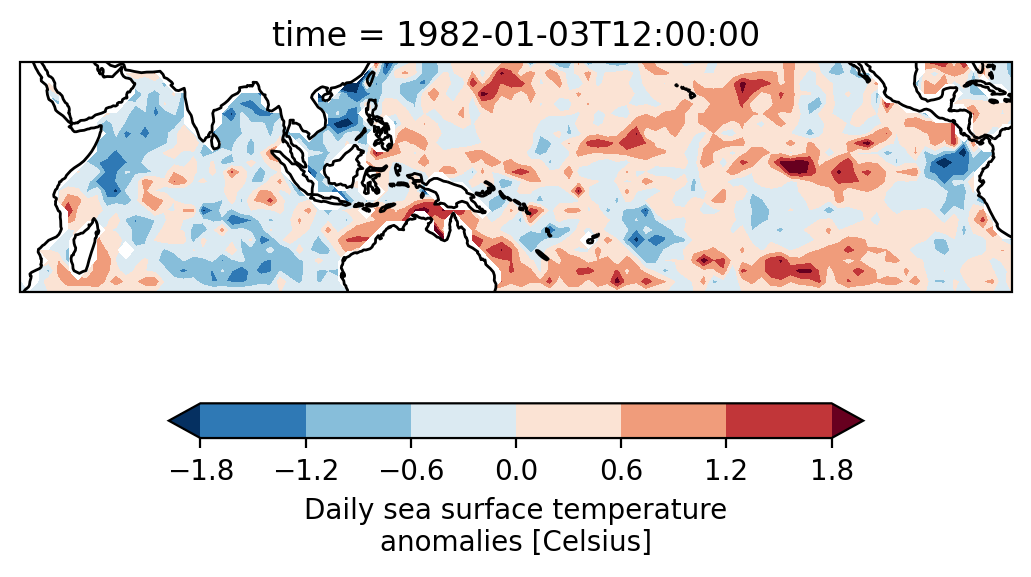

In [6]:
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=160, min_latitude=-45, max_latitude=45)))

raw_dataset['anom'].isel(time=2).isel(zlev=0).plot.contourf(
    ax=ax,
    transform=ccrs.PlateCarree(),  # this is important!
    # usual xarray stuff
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.7},
    robust=True,
)
ax.coastlines()

In [9]:
# Calculating 5 day running mean
rolling_dataset = raw_dataset.rolling(time=5, center=True).mean().dropna(dim='time', how='all')
rolling_dataset

<xarray.Dataset> Size: 153MB
Dimensions:  (time: 15336, lat: 24, lon: 104, zlev: 1)
Coordinates:
  * time     (time) datetime64[ns] 123kB 1982-01-03T12:00:00 ... 2023-12-29T1...
  * lat      (lat) float64 192B -30.0 -27.5 -25.0 -22.5 ... 20.0 22.5 25.0 27.5
  * lon      (lon) float64 832B 30.0 32.5 35.0 37.5 ... 280.0 282.5 285.0 287.5
Dimensions without coordinates: zlev
Data variables:
    anom     (time, zlev, lat, lon) float32 153MB dask.array<chunksize=(5, 1, 24, 104), meta=np.ndarray>

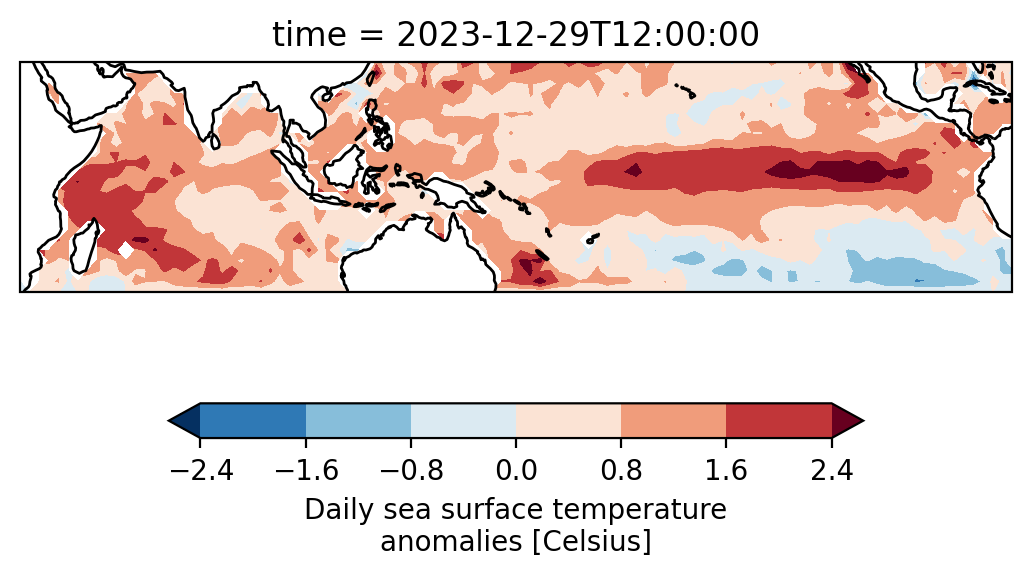

In [11]:
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=160, min_latitude=-45, max_latitude=45)))

rolling_dataset['anom'].isel(time=-1).isel(zlev=0).plot.contourf(
    ax=ax,
    transform=ccrs.PlateCarree(),  # this is important!
    # usual xarray stuff
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.7},
    robust=True,
)
ax.coastlines()

In [13]:
rolling_dataset.to_netcdf("./processed_data/processed_data.nc")